In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import random
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.utils import resample
from sklearn import metrics
import numpy as np
import warnings
warnings.filterwarnings('ignore')
random.seed(1)

df = pd.read_csv('Datasets_Zrive/feature_frame.csv')

### Data Transformation

In [2]:
df.columns

Index(['variant_id', 'product_type', 'order_id', 'user_id', 'created_at',
       'order_date', 'user_order_seq', 'outcome', 'ordered_before',
       'abandoned_before', 'active_snoozed', 'set_as_regular',
       'normalised_price', 'discount_pct', 'vendor', 'global_popularity',
       'count_adults', 'count_children', 'count_babies', 'count_pets',
       'people_ex_baby', 'days_since_purchase_variant_id',
       'avg_days_to_buy_variant_id', 'std_days_to_buy_variant_id',
       'days_since_purchase_product_type', 'avg_days_to_buy_product_type',
       'std_days_to_buy_product_type'],
      dtype='object')

In [3]:
#Filtering for Valid Orders
df_orders = df.groupby(by='order_id')['outcome'].sum()
valid_orders = df_orders[df_orders>=5].index.to_list() 
df = df[df['order_id'].isin(valid_orders)]
df

,variant_id,product_type,order_id,user_id,created_at,order_date,user_order_seq,outcome,ordered_before,abandoned_before,...,count_children,count_babies,count_pets,people_ex_baby,days_since_purchase_variant_id,avg_days_to_buy_variant_id,std_days_to_buy_variant_id,days_since_purchase_product_type,avg_days_to_buy_product_type,std_days_to_buy_product_type
0,33826472919172,ricepastapulses,2807985930372,3482464092292,2020-10-05 16:46:19,2020-10-05 00:00:00,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.276180
1,33826472919172,ricepastapulses,2808027644036,3466586718340,2020-10-05 17:59:51,2020-10-05 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.276180
2,33826472919172,ricepastapulses,2808099078276,3481384026244,2020-10-05 20:08:53,2020-10-05 00:00:00,4,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.276180
3,33826472919172,ricepastapulses,2808393957508,3291363377284,2020-10-06 08:57:59,2020-10-06 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.276180
5,33826472919172,ricepastapulses,2808434524292,3479090790532,2020-10-06 10:50:23,2020-10-06 00:00:00,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.276180
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2880541,33826439594116,healthcarevitamins,3643241300100,3864791220356,2021-03-03 12:56:04,2021-03-03 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,34.0,27.693045,30.0,34.0,27.451392
2880544,33826439594116,healthcarevitamins,3643254800516,3893722808452,2021-03-03 13:19:28,2021-03-03 00:00:00,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,34.0,27.693045,30.0,34.0,27.451392
2880545,33826439594116,healthcarevitamins,3643274788996,3883757174916,2021-03-03 13:57:35,2021-03-03 00:00:00,4,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,34.0,27.693045,30.0,34.0,27.451392
2880546,33826439594116,healthcarevitamins,3643283734660,3874925314180,2021-03-03 14:14:24,2021-03-03 00:00:00,7,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,34.0,27.693045,30.0,34.0,27.451392


In [4]:
#Removing ID Variables and adding new features
df = df.drop(['created_at','user_id','variant_id','order_id'], axis=1)
df['order_date'] = pd.to_datetime(df['order_date'])
df['week_day']= df['order_date'].dt.weekday
df['month']= df['order_date'].dt.month
df['order_date'] = df['order_date'].dt.date

In [5]:
#Filtering for train, val and test by date.
df = df.sort_values(by='order_date')
df_date_cumsum = df.groupby('order_date')['outcome'].count().cumsum()/len(df)
df_val_index = df_date_cumsum[df_date_cumsum>0.7].index[0]
df_test_index = df_date_cumsum[df_date_cumsum>0.9].index[0]

print(f'Train split from {df_date_cumsum.index[0]}, till {df_val_index}')
print(f'Validation split from {df_val_index}, till {df_test_index}')
print(f'Test split from {df_test_index}, till {df_date_cumsum.index[-1]}')

Train split from 2020-10-05, till 2021-02-09
Validation split from 2021-02-09, till 2021-02-25
Test split from 2021-02-25, till 2021-03-03


In [6]:
df_train = df[df.order_date < df_val_index].drop(['order_date'], axis=1)
df_val = df[df.order_date.between(df_val_index,df_test_index, inclusive='left')].drop(['order_date'], axis=1)
df_test = df[df.order_date >= df_test_index].drop(['order_date'], axis=1)

In [7]:
print(len(df.vendor.value_counts()))
print(len(df.product_type.value_counts()))

264
62


In [23]:
df_categorical_features = ['product_type','vendor']
df_date_features = ['week_day','month']
df_numeric_features = ['user_order_seq', 'ordered_before', 'abandoned_before', 'active_snoozed', 'set_as_regular', 'normalised_price',
 'discount_pct', 'global_popularity', 'count_adults', 'count_children', 'count_babies', 'count_pets', 'people_ex_baby', 'days_since_purchase_variant_id', 'avg_days_to_buy_variant_id',
 'std_days_to_buy_variant_id', 'days_since_purchase_product_type', 'avg_days_to_buy_product_type','std_days_to_buy_product_type']

### Main Models

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

def get_reg_model(penalty:str ,features: pd.DataFrame) -> GridSearchCV:
    '''
    Trains a Logistic Regression Model with the desired penalty and returns the model.
    '''
        
    param_grid = {
        'clf__C': [0.001, 0.01, 0.1, 1, 10, 100],
        'clf__penalty': [penalty]}
    
    if penalty == "l1":
        param_grid['clf__solver'] = ['liblinear']

    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', LogisticRegression())])

    grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1)
    grid_search.fit(features, df_train['outcome'])

    return grid_search

In [10]:
def draw_roc_prc(real_y: pd.Series, y_pred_list: np.ndarray, labels: list, xlim = [0.0, 1.0],ylim = [0.0, 1.05]):
    '''
    Plots a ROC and a Precision and Recall curve.
    '''
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))

    ax[0].set_title(f'ROC curve')
    ax[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax[0].set_xlim(xlim)
    ax[0].set_ylim(ylim)
    ax[0].set_xlabel('False Positive Rate')
    ax[0].set_ylabel('True Positive Rate')

    ax[1].set_xlabel('Recall')
    ax[1].set_ylabel('Precision')
    ax[1].set_title('Precision-Recall Curve')
    
    fig.suptitle('ROC and PR curves for Models')

    colors = ['darkorange', 'blue', 'green', 'red', 'purple']

    for i, y_pred in enumerate(y_pred_list):
        fpr, tpr, thresholds = metrics.roc_curve(real_y, y_pred)
        roc_auc = metrics.auc(fpr, tpr)
        ax[0].plot(fpr, tpr, color=colors[i], label=f'{labels[i]} (AUC = {roc_auc:.3f})')

        precision, recall, thresholds = metrics.precision_recall_curve(real_y, y_pred)
        average_precision = metrics.average_precision_score(real_y, y_pred)
        ax[1].plot(recall, precision, color=colors[i], label=f'{labels[i]} (AUC-PR = {average_precision:.3f})')

    ax[0].legend(loc='lower right')
    ax[1].legend(loc='upper right')

    plt.tight_layout()
    plt.show()

In [11]:
#Linear Logistic Regression Models
grid_search_l1 = get_reg_model('l1', df_train.loc[:,df_numeric_features])
grid_search_l2 = get_reg_model('l2', df_train.loc[:,df_numeric_features])
grid_search_base = get_reg_model(None, df_train.loc[:,df_numeric_features])

/Users/alvarodda/Library/Caches/pypoetry/virtualenvs/test-jAC2_l5G-py3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/alvarodda/Library/Caches/pypoetry/virtualenvs/test-jAC2_l5G-py3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/alvarodda/Library/Caches/pypoetry/virtualenvs/test-jAC2_l5G-py3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/alvarodda/Library/Caches/pypoetry/virtualenvs/test-jAC2_l5G-py3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/alvarodda/Library/Caches/pypoetry/virtualenvs/tes

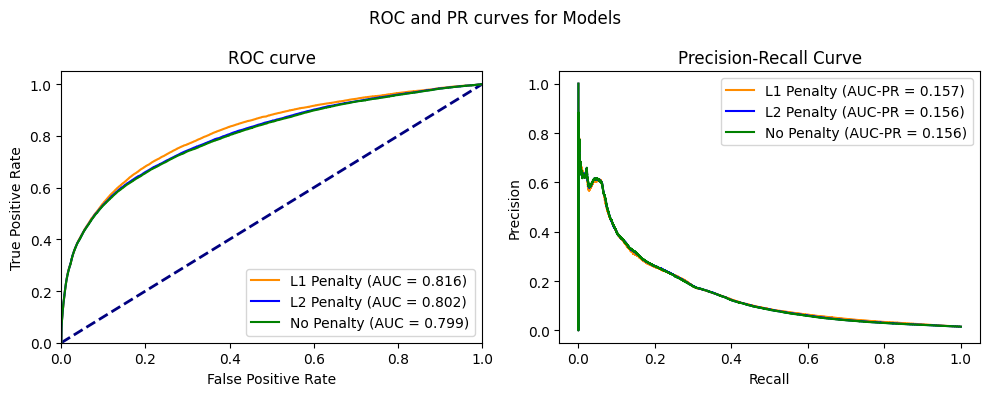

In [12]:
# Train Error
list_train_probs = [grid_search_l1.predict_proba(df_train.loc[:,df_numeric_features])[:,1],
                    grid_search_l2.predict_proba(df_train.loc[:,df_numeric_features])[:,1],
                    grid_search_base.predict_proba(df_train.loc[:,df_numeric_features])[:,1]]

labels = ['L1 Penalty','L2 Penalty','No Penalty']
draw_roc_prc(df_train['outcome'], list_train_probs,labels)

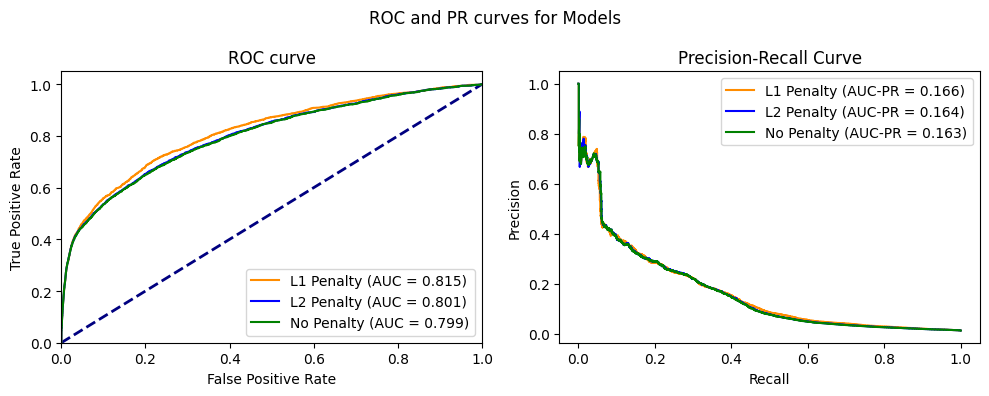

In [13]:
# For validation Data

list_train_probs = [grid_search_l1.predict_proba(df_test.loc[:,df_numeric_features])[:,1],
                    grid_search_l2.predict_proba(df_test.loc[:,df_numeric_features])[:,1],
                    grid_search_base.predict_proba(df_test.loc[:,df_numeric_features])[:,1]]

labels = ['L1 Penalty','L2 Penalty','No Penalty']
draw_roc_prc(df_test['outcome'], list_train_probs, labels)

In [14]:
#FREQUENCY ENCODING of Categorical Variables for train and validation dataset

vendor_value_counts = df_train.vendor.value_counts()
product_type_counts = df_train.product_type.value_counts()

df_train['vendor'] = df_train['vendor'].apply(lambda x: vendor_value_counts.get(x, 0)).astype('int32')
df_train['product_type'] = df_train['product_type'].apply(lambda x: product_type_counts.get(x, 0)).astype('int32')

df_val['vendor'] = df_val['vendor'].apply(lambda x: vendor_value_counts.get(x, 0)).astype('int32')
df_val['product_type'] = df_val['product_type'].apply(lambda x: product_type_counts.get(x, 0)).astype('int32')

#Logistic Regression Models with Categorical Variables and date features
grid_search_cat_l2 = get_reg_model('l2', df_train.loc[:,df_numeric_features+df_categorical_features+df_date_features])
grid_search_cat_base = get_reg_model(None, df_train.loc[:,df_numeric_features+df_categorical_features+df_date_features])

/Users/alvarodda/Library/Caches/pypoetry/virtualenvs/test-jAC2_l5G-py3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/alvarodda/Library/Caches/pypoetry/virtualenvs/test-jAC2_l5G-py3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/alvarodda/Library/Caches/pypoetry/virtualenvs/test-jAC2_l5G-py3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/alvarodda/Library/Caches/pypoetry/virtualenvs/test-jAC2_l5G-py3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/alvarodda/Library/Caches/pypoetry/virtualenvs/tes

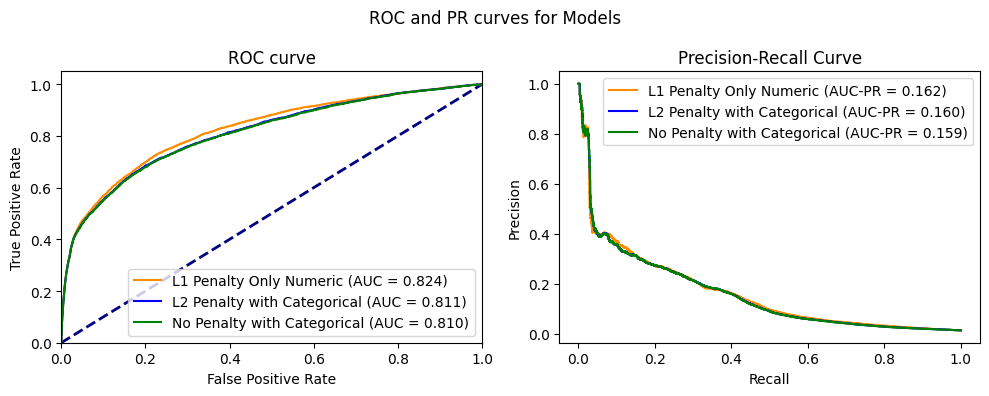

In [15]:
list_train_probs = [grid_search_l1.predict_proba(df_val.loc[:,df_numeric_features])[:,1],
                    grid_search_cat_l2.predict_proba(df_val.loc[:,df_numeric_features+df_categorical_features+df_date_features])[:,1],
                    grid_search_cat_base.predict_proba(df_val.loc[:,df_numeric_features+df_categorical_features+df_date_features])[:,1]]

labels = ['L1 Penalty Only Numeric','L2 Penalty with Categorical','No Penalty with Categorical']
draw_roc_prc(df_val['outcome'], list_train_probs, labels)

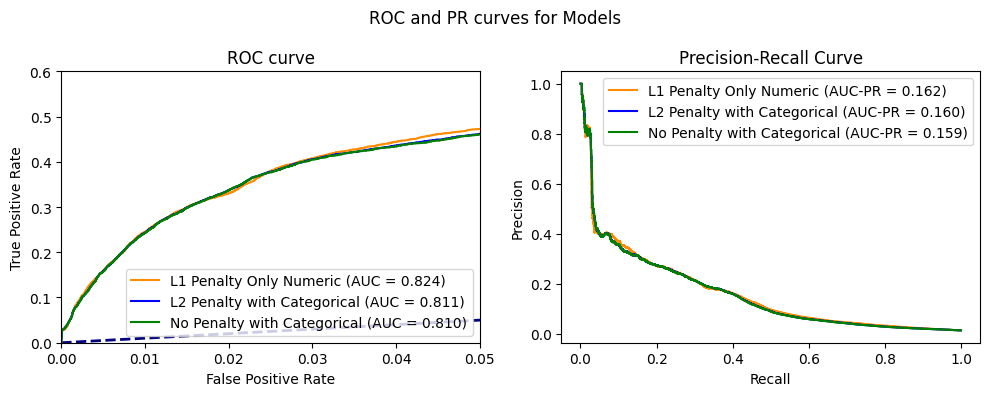

In [16]:
#Checking the ROC Curves for the values we are actually going to work with, FPR of 0-0.05%

list_train_probs = [grid_search_l1.predict_proba(df_val.loc[:,df_numeric_features])[:,1],
                    grid_search_cat_l2.predict_proba(df_val.loc[:,df_numeric_features+df_categorical_features+df_date_features])[:,1],
                    grid_search_cat_base.predict_proba(df_val.loc[:,df_numeric_features+df_categorical_features+df_date_features])[:,1]]

labels = ['L1 Penalty Only Numeric','L2 Penalty with Categorical','No Penalty with Categorical']
draw_roc_prc(df_val['outcome'], list_train_probs, labels,[0,0.05],[0,0.6])

No improvements, so they won't be used for the validation comparison as using them only inreases the computational cost. We choose the best performing model, although they are all mostly the same.

### Validation Comparison

In [17]:

print(metrics.confusion_matrix(df_val['outcome'],grid_search_l1.predict(df_val.loc[:,df_numeric_features])))
print(metrics.accuracy_score(df_val['outcome'],grid_search_l1.predict(df_val.loc[:,df_numeric_features])))
print(metrics.f1_score(df_val['outcome'],grid_search_l1.predict(df_val.loc[:,df_numeric_features])))

[[422785    398]
 [  5531    270]]
0.9861789717099007
0.08347503478126449


Suppose we wanted to minimize the FPR to 0.0001% to be extremely careful, then the confusion matrix would look like:

In [22]:
grid_search_l1

fpr, tpr, thresholds = metrics.roc_curve(df_val['outcome'],grid_search_l1.predict_proba(df_val.loc[:,df_numeric_features])[:,1])
threshold_for_fpr = thresholds[np.argmin(fpr <= 0.0001)]
print(threshold_for_fpr)

grid_search_l1_val_pred = (grid_search_l1.predict_proba(df_val.loc[:,df_numeric_features])[:,1] >= threshold_for_fpr).astype(int)

print(metrics.confusion_matrix(df_val['outcome'],grid_search_l1_val_pred))

0.8184061581468233
[[423139     44]
 [  5646    155]]


### Test Comparison

All three logistic regression models performed the same, therefore I decided to choose one of them, the L1 regularization one.

In [19]:
print(metrics.confusion_matrix(df_test['outcome'],grid_search_l1.predict(df_test.loc[:,df_numeric_features])))
print(metrics.accuracy_score(df_test['outcome'],grid_search_l1.predict(df_test.loc[:,df_numeric_features])))
print(metrics.f1_score(df_test['outcome'],grid_search_l1.predict(df_test.loc[:,df_numeric_features])))

[[217785    113]
 [  2665    156]]
0.9874138610631618
0.10097087378640777
